In [2]:
# Importing all the necessary packages
import pandas as pd
import numpy as np
import nltk
import string
import re
import gensim
import gensim.downloader as api
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

c:\Users\laris\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
%pip install pandas==1.5.3 
%pip install pyLDAvis
%pip install pyLDAvis.gensim

  Obtaining dependency information for pandas==1.5.3 from https://files.pythonhosted.org/packages/da/6d/1235da14daddaa6e47f74ba0c255358f0ce7a6ee05da8bf8eb49161aa6b5/pandas-1.5.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.3 MB ? eta -:--:--
   - -------------------------------------- 0.4/10.3 MB 13.9 MB/s eta 0:00:01
   ------ --------------------------------- 1.7/10.3 MB 21.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.3/10.3 MB 18.0 MB/s eta 0:00:01
   ------------ --------------------------- 3.1/10.3 MB 17.9 MB/s eta 0:00:01
   -------------- ------------------------- 3.8/10.3 MB 17.5 MB/s eta 0:00:01
   ---------------- ----------------------- 4.1/10.3 MB 17.6 MB/s eta 0:00:01
   ------------------ --------------------- 4.8/10.3 MB 15.2 MB/s eta 0:00:01
   --------------------- ------------------ 5.4/10.3 MB 15.1 MB/s eta 0:00:01
   ------------------------ --------------- 6.3/10.3 MB 15.6 MB/s eta 0:00:01
   ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


  Obtaining dependency information for pandas>=2.0.0 from https://files.pythonhosted.org/packages/ab/63/966db1321a0ad55df1d1fe51505d2cdae191b84c907974873817b0a6e849/pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl (11.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [9]:
# please change the file path accordingly to your needs

df_w=pd.read_csv('C:/Users/laris/Downloads/western_analysts_tweets.csv/western_analysts_tweets.csv', encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING

df_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16727 entries, 0 to 16726
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               16727 non-null  float64
 1   conversation_id  16727 non-null  float64
 2   created_at       16727 non-null  object 
 3   date             16727 non-null  object 
 4   time             16727 non-null  object 
 5   timezone         16727 non-null  int64  
 6   user_id          16727 non-null  float64
 7   username         16727 non-null  object 
 8   name             16727 non-null  object 
 9   place            531 non-null    object 
 10  tweet            16727 non-null  object 
 11  language         16727 non-null  object 
 12  mentions         16727 non-null  object 
 13  urls             16727 non-null  object 
 14  photos           16727 non-null  object 
 15  replies_count    16727 non-null  int64  
 16  retweets_count   16727 non-null  int64  
 17  likes_count 

In [10]:
df_r=pd.read_csv("C:/Users/laris/Downloads/russian_propaganda_tweets.csv/russian_propaganda_tweets.csv" ,encoding='latin1') #IMPORTANT - THIS FILE HAS LATIN1 ENCODING
#some of the columns were causing issues so they were already removed in the csv file
df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22602 entries, 0 to 22601
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               22602 non-null  float64
 1   conversation_id  22602 non-null  float64
 2   created_at       22602 non-null  object 
 3   date             22602 non-null  object 
 4   time             22602 non-null  object 
 5   tweet            22602 non-null  object 
 6   tweet.1          22602 non-null  object 
 7   retweets_count   22602 non-null  int64  
 8   likes_count      22602 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.6+ MB


We can see that for Russian dataset we have a bit more values (22602 compared to 16727 for the Western dataset). So there is a slight imbalance, which might impact the result from the classifier later on.

In [11]:
#Keeping only the important columns (likes_count and retweets_count might be used only alternatively for a classifier?)
columns_to_keep = ['created_at', 'tweet', 'likes_count','retweets_count']
df_w = df_w[columns_to_keep]
df_r = df_r[columns_to_keep]

df_w.head()

,created_at,tweet,likes_count,retweets_count
0,2022-02-24 02:01:32 GTB Standard Time,UN Security Council to hold emergency session ...,112,40
1,2022-02-24 02:02:33 GTB Standard Time,At 4:30 Kyiv time. Most urgent after years ht...,83,28
2,2022-02-24 02:03:39 GTB Standard Time,Rare meeting of UNSC the same day(NY time) whe...,78,17
3,2022-02-24 02:15:19 GTB Standard Time,Two Turkish Air Force Airbus A400M entered Ukr...,351,123
4,2022-02-24 02:19:59 GTB Standard Time,Another cyber attack targeting the website of ...,389,180


In [12]:
df_r.head()

,created_at,tweet,likes_count,retweets_count
0,2022-02-24 14:01:58 GTB Standard Time,https://t.co/4dVHUFQVd4,58,5
1,2022-02-24 14:24:32 GTB Standard Time,?? President Vladimir Putin: We have to take b...,1243,315
2,2022-02-24 14:42:53 GTB Standard Time,?? Vladimir Putin: Over the past 30 years we h...,2881,946
3,2022-02-24 14:50:06 GTB Standard Time,President #Putin: For 8 years Russia has been ...,904,281
4,2022-02-24 14:56:54 GTB Standard Time,?? Vladimir Putin: A veritable empire of lies...,2016,668


In [13]:
#Adding additional column representing whether the post is from Russian perspective or not (0 for western persepective, 1 for Russian)
df_w = df_w.assign(Label=0)
df_r = df_r.assign(Label=1)


In [14]:
# From the date column, keep only the date info, and create a new column which keeps only the month info

from datetime import datetime

df_w['date'] = df_w['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())
df_r['date'] = df_r['created_at'].apply(lambda x: re.search(r'\d{4}-\d{2}-\d{2}', x).group())

df_w['month'] = pd.to_datetime(df_w['date'])
df_w['month'] = df_w['month'].dt.month

df_r['month'] = pd.to_datetime(df_r['date'])
df_r['month'] = df_r['month'].dt.month

print(df_w.head())

                              created_at  \
0  2022-02-24 02:01:32 GTB Standard Time   
1  2022-02-24 02:02:33 GTB Standard Time   
2  2022-02-24 02:03:39 GTB Standard Time   
3  2022-02-24 02:15:19 GTB Standard Time   
4  2022-02-24 02:19:59 GTB Standard Time   

                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  
0              40      0  2022-02-24      2  
1              28      0  2022-02-24      2  
2              17      0  2022-02-24      2  
3             123      0  2022-02-24      2  
4             180      0  2022-02-24      2  


In [15]:
df_r.drop('created_at',axis=1,inplace=True) #this column is no longer needed
df_r.head()

,tweet,likes_count,retweets_count,Label,date,month
0,https://t.co/4dVHUFQVd4,58,5,1,2022-02-24,2
1,?? President Vladimir Putin: We have to take b...,1243,315,1,2022-02-24,2
2,?? Vladimir Putin: Over the past 30 years we h...,2881,946,1,2022-02-24,2
3,President #Putin: For 8 years Russia has been ...,904,281,1,2022-02-24,2
4,?? Vladimir Putin: A veritable empire of lies...,2016,668,1,2022-02-24,2


In [16]:
df_w.drop('created_at',axis=1, inplace=True) #this column is no longer needed
df_w.head()

,tweet,likes_count,retweets_count,Label,date,month
0,UN Security Council to hold emergency session ...,112,40,0,2022-02-24,2
1,At 4:30 Kyiv time. Most urgent after years ht...,83,28,0,2022-02-24,2
2,Rare meeting of UNSC the same day(NY time) whe...,78,17,0,2022-02-24,2
3,Two Turkish Air Force Airbus A400M entered Ukr...,351,123,0,2022-02-24,2
4,Another cyber attack targeting the website of ...,389,180,0,2022-02-24,2


In [17]:
print(df_r.value_counts('month'))
print(df_w.value_counts('month'))

month
4    9722
3    8960
5    2308
2    1612
Name: count, dtype: int64
month
3    7501
4    6179
2    1780
5    1267
Name: count, dtype: int64


With the dates, we can again see there will be some imbalance, as the majority of the tweets are in months 3 and 4, March and April.

In [18]:
#Checking for missing values
print(df_w.isnull().sum())
print(df_r.isnull().sum())

# No missing values in the dataset

tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64
tweet             0
likes_count       0
retweets_count    0
Label             0
date              0
month             0
dtype: int64


In [19]:
#Preprocess and clean the tweets column

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        # Remove URLs
        text = re.sub(r"https?://\S+", "", text)
        # Remove non-alphanumeric characters and extra whitespaces
        text = re.sub(r"[^a-zA-Z\s']", " ", text)
        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text)
        # Remove hashtags (words starting with #)
        text = re.sub(r"#\w+", "", text)
        # Remove mentions (words starting with @)
        text = re.sub(r"@\w+", "", text)
        # Remove punctuation and special characters (excluding apostrophes)
        text = re.sub(r"[^\w\s']", "", text)
        # Remove newline characters
        text = re.sub(r"[\n\r]", " ", text)
        # Convert to lowercase
        text = text.lower()
        return text

    # Apply the cleaning text function
    cleaned_text = clean_text(text)

    # Tokenize the cleaned text
    tokens = word_tokenize(cleaned_text)

    # Remove stopwords, punctuation, and lemmatize
    new_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w not in punctuation and len(w) > 3]

    return (new_tokens)

cleaned_tokens_w = df_w['tweet'].apply(preprocess_text)
cleaned_tokens_r = df_r['tweet'].apply(preprocess_text)

print(cleaned_tokens_w.head(10))

print(cleaned_tokens_r.head(10))

0    [security, council, hold, emergency, session, ...
1                           [kyiv, time, urgent, year]
2               [rare, meeting, unsc, time, requested]
3    [turkish, force, airbus, entered, ukrainian, a...
4    [another, cyber, attack, targeting, website, s...
5    [secretary, state, blinken, belief, russia, in...
6    [clash, audible, night, mariupol, herooftheday...
7    [blinken, doubling, security, diplomatic, huma...
8    [landed, czech, republic, practicing, quick, t...
9    [israeli, civilian, aircraft, flying, western,...
Name: tweet, dtype: object
0                                                   []
1    [president, vladimir, putin, take, bold, immed...
2    [vladimir, putin, past, year, patiently, tryin...
3    [president, putin, year, russia, everything, p...
4    [vladimir, putin, veritable, empire, lie, crea...
5                            [asbmilitary, good, luck]
6    [president, putin, asked, russia, help, decisi...
7    [ukrainian, border, guard, crosse

In [20]:
#Appending these cleaned tokens back to the dataframe

df_w['cleaned_tokens'] = df_w['tweet'].apply(preprocess_text)
df_r['cleaned_tokens'] = df_r['tweet'].apply(preprocess_text)

# Create BOW representations of words for both datasets

In [21]:
# Create a Dictionary object which is mapping unique word tokens to unique IDs
dictionary_w = corpora.Dictionary(cleaned_tokens_w)
print(len(dictionary_w.values()))

dictionary_r = corpora.Dictionary(cleaned_tokens_r)
print(len(dictionary_r.values()))

16817
23750


In [23]:
#Filter out those words tokens that appear in less than 15 documents and more than half of the documents, capping the max at 50000

dictionary_w.filter_extremes(no_below=15, no_above=0.5, keep_n=50000)
print(len(dictionary_w.iteritems()))

dictionary_r.filter_extremes(no_below=15, no_above=0.5, keep_n=50000)
print(len(dictionary_r.iteritems()))

2011
2342


In [24]:
# Convert the list with tokenized tweets to BOW representation
bow_corpus_w = [dictionary_w.doc2bow(tokens) for tokens in cleaned_tokens_w]

bow_corpus_r = [dictionary_r.doc2bow(tokens) for tokens in cleaned_tokens_r]

In [26]:
#Preview some of the BOW representations to get the idea of the format

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_w[i]))

for i in range(5):
    print("Document {}: {}".format(i+1, bow_corpus_r[i]))

Document 1: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]
Document 2: [(7, 1), (8, 1), (9, 1)]
Document 3: [(8, 1), (10, 1), (11, 1)]
Document 4: [(6, 1), (7, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]
Document 5: [(5, 1), (6, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
Document 1: []
Document 2: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]
Document 3: [(13, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)]
Document 4: [(5, 1), (11, 1), (12, 1), (13, 1), (15, 2), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)]
Document 5: [(13, 1), (18, 1), (25, 1), (34, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55

In [27]:
#Append the BOW into separate col in our dataframes
bow_scores_w = [dict(doc) for doc in bow_corpus_w]
bow_scores_r = [dict(doc) for doc in bow_corpus_r]

df_w['bow_scores'] = bow_scores_w
df_r['bow_scores'] = bow_scores_r

# Create TF IDF representation from the BOW corpus


In [28]:
#TF IDF is a more accurate and precise representation than BOW

tfidf_w = models.TfidfModel(bow_corpus_w)

tfidf_r = models.TfidfModel(bow_corpus_r)

In [29]:
corpus_tfidf_w = tfidf_w[bow_corpus_w]

corpus_tfidf_r = tfidf_r[bow_corpus_r]

In [30]:
# Convert the TF-IDF representations into a list of dictionaries where each dictionary represents TF-IDF scores for a document
tfidf_scores_w = [dict(corpus_tfidf_w[i]) for i in range(len(corpus_tfidf_w))]
tfidf_scores_r = [dict(corpus_tfidf_r[i]) for i in range(len(corpus_tfidf_r))]

# Append the TF-IDF scores as a separate column in the DataFrame
df_w['tfidf_scores'] = tfidf_scores_w
df_r['tfidf_scores'] = tfidf_scores_r

# Print the DataFrame to verify the results
print(df_w.head())
print(df_r.head())


                                               tweet  likes_count  \
0  UN Security Council to hold emergency session ...          112   
1  At 4:30 Kyiv time. Most urgent after years  ht...           83   
2  Rare meeting of UNSC the same day(NY time) whe...           78   
3  Two Turkish Air Force Airbus A400M entered Ukr...          351   
4  Another cyber attack targeting the website of ...          389   

   retweets_count  Label        date  month  \
0              40      0  2022-02-24      2   
1              28      0  2022-02-24      2   
2              17      0  2022-02-24      2   
3             123      0  2022-02-24      2   
4             180      0  2022-02-24      2   

                                      cleaned_tokens  \
0  [security, council, hold, emergency, session, ...   
1                         [kyiv, time, urgent, year]   
2             [rare, meeting, unsc, time, requested]   
3  [turkish, force, airbus, entered, ukrainian, a...   
4  [another, cyber, at

# Saving the cleaned datasets, used for other tasks in the project




In [31]:
#Save this dataframe view as new csv for easier reuse
#Note that this saves the df into the session in colab - you need to download the csv for reusal

df_w.to_csv('df_w.csv', index=False)
df_r.to_csv('df_r.csv', index=False)

In [32]:
# Also produce a merged dataframe of the both- which will be mainly used for classification
merged_df = pd.concat([df_w, df_r], ignore_index=True)

print(merged_df.info())

merged_df.to_csv('merged_df.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39329 entries, 0 to 39328
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           39329 non-null  object
 1   likes_count     39329 non-null  int64 
 2   retweets_count  39329 non-null  int64 
 3   Label           39329 non-null  int64 
 4   date            39329 non-null  object
 5   month           39329 non-null  int32 
 6   cleaned_tokens  39329 non-null  object
 7   bow_scores      39329 non-null  object
 8   tfidf_scores    39329 non-null  object
dtypes: int32(1), int64(3), object(5)
memory usage: 2.6+ MB
None


# Run LDA model with TF IDF (I also tried with BOW, not that much difference)

In [39]:
lda_model_w = gensim.models.LdaMulticore(corpus_tfidf_w, num_topics=2,
                                       id2word=dictionary_w, iterations = 5)

lda_model_r = gensim.models.LdaMulticore(corpus_tfidf_r, num_topics=3,
                                       id2word=dictionary_r, iterations = 5)

In [38]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, iterations=5, passes=2)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

start = 2
limit = 10
step = 1

# Compute coherence values for Western tweets
coherence_values_w = compute_coherence_values(dictionary_w, corpus_tfidf_w, cleaned_tokens_w, start, limit, step)

# Compute coherence values for Russian tweets
coherence_values_r = compute_coherence_values(dictionary_r, corpus_tfidf_r, cleaned_tokens_r, start, limit, step)

# Print coherence values for each number of topics
for i, num_topics in enumerate(range(start, limit, step)):
    print(f'Number of topics: {num_topics} | Coherence Score (Western): {coherence_values_w[i]:.4f} | Coherence Score (Russian): {coherence_values_r[i]:.4f}')

# Find the number of topics with the highest coherence score
optimal_num_topics_w = start + coherence_values_w.index(max(coherence_values_w))
optimal_num_topics_r = start + coherence_values_r.index(max(coherence_values_r))

print(f'Optimal number of topics for Western tweets: {optimal_num_topics_w}')
print(f'Optimal number of topics for Russian tweets: {optimal_num_topics_r}')



Number of topics: 2 | Coherence Score (Western): 0.4523 | Coherence Score (Russian): 0.4023
Number of topics: 3 | Coherence Score (Western): 0.4324 | Coherence Score (Russian): 0.4184
Number of topics: 4 | Coherence Score (Western): 0.3996 | Coherence Score (Russian): 0.3709
Number of topics: 5 | Coherence Score (Western): 0.4023 | Coherence Score (Russian): 0.3424
Number of topics: 6 | Coherence Score (Western): 0.4078 | Coherence Score (Russian): 0.3630
Number of topics: 7 | Coherence Score (Western): 0.4292 | Coherence Score (Russian): 0.3628
Number of topics: 8 | Coherence Score (Western): 0.4283 | Coherence Score (Russian): 0.3724
Number of topics: 9 | Coherence Score (Western): 0.3966 | Coherence Score (Russian): 0.3882
Optimal number of topics for Western tweets: 2
Optimal number of topics for Russian tweets: 3


In [47]:
from gensim.models import CoherenceModel, LdaMulticore
import multiprocessing
from multiprocessing import cpu_count


def compute_coherence_values(dictionary, corpus, texts, start, limit, step, alpha, beta):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, alpha=alpha, eta=beta, iterations=5, passes=2, workers=cpu_count() - 1)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

start = 2
limit = 10
step = 1

alpha_values = ['symmetric', 'asymmetric']
beta_values = ['symmetric']

best_coherence_score = -1
best_num_topics = -1
best_alpha = None
best_beta = None

for alpha in alpha_values:
    for beta in beta_values:
        coherence_values = compute_coherence_values(dictionary_w, corpus_tfidf_w, cleaned_tokens_w, start, limit, step, alpha, beta)
        max_coherence_score = max(coherence_values)
        if max_coherence_score > best_coherence_score:
            best_coherence_score = max_coherence_score
            best_num_topics = start + coherence_values.index(max_coherence_score)
            best_alpha = alpha
            best_beta = beta

print(f'Best number of topics: {best_num_topics}')
print(f'Best alpha: {best_alpha}')
print(f'Best beta: {best_beta}')
print(f'Best coherence score: {best_coherence_score}')


Best number of topics: 7
Best alpha: asymmetric
Best beta: symmetric
Best coherence score: 0.4639359484005913


In [48]:
#Doing the same hyperparameter tuning for the Russian dataset

start = 2
limit = 10
step = 1

alpha_values = ['symmetric', 'asymmetric']
beta_values = ['symmetric']

best_coherence_score = -1
best_num_topics = -1
best_alpha = None
best_beta = None

for alpha in alpha_values:
    for beta in beta_values:
        coherence_values = compute_coherence_values(dictionary_r, corpus_tfidf_r, cleaned_tokens_r, start, limit, step, alpha, beta)
        max_coherence_score = max(coherence_values)
        if max_coherence_score > best_coherence_score:
            best_coherence_score = max_coherence_score
            best_num_topics = start + coherence_values.index(max_coherence_score)
            best_alpha = alpha
            best_beta = beta

print(f'Best number of topics: {best_num_topics}')
print(f'Best alpha: {best_alpha}')
print(f'Best beta: {best_beta}')
print(f'Best coherence score: {best_coherence_score}')


Best number of topics: 3
Best alpha: asymmetric
Best beta: symmetric
Best coherence score: 0.464210180723283


In [40]:
for idx, topic in lda_model_w.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"russian" + 0.010*"ukraine" + 0.009*"ukrainian" + 0.006*"russia" + 0.006*"force" + 0.005*"kyiv" + 0.005*"tank" + 0.005*"kharkiv" + 0.004*"video" + 0.004*"destroyed"
Topic: 1 
Words: 0.010*"russian" + 0.009*"ukraine" + 0.007*"ukrainian" + 0.006*"russia" + 0.006*"force" + 0.005*"kyiv" + 0.005*"destroyed" + 0.004*"video" + 0.004*"region" + 0.004*"vehicle"


In [41]:
for idx, topic in lda_model_r.print_topics(-1): # -1 corresponds to all topics
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"russian" + 0.007*"russia" + 0.007*"ukraine" + 0.005*"geromanat" + 0.005*"like" + 0.005*"ukrainian" + 0.004*"would" + 0.004*"nazi" + 0.004*"time" + 0.004*"military"
Topic: 1 
Words: 0.007*"ukraine" + 0.007*"russia" + 0.007*"russian" + 0.005*"people" + 0.005*"exactly" + 0.005*"ukrainian" + 0.004*"like" + 0.004*"mariupol" + 0.004*"think" + 0.004*"know"
Topic: 2 
Words: 0.008*"ukraine" + 0.008*"russia" + 0.007*"russian" + 0.005*"people" + 0.005*"know" + 0.005*"ukrainian" + 0.005*"like" + 0.004*"nazi" + 0.004*"force" + 0.003*"much"


In [42]:
%matplotlib inline

vis = gensimvis.prepare(lda_model_w, corpus_tfidf_w, dictionary_w)
pyLDAvis.display(vis)

C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [43]:
%matplotlib inline
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


vis = gensimvis.prepare(lda_model_r, corpus_tfidf_r, dictionary_r)
pyLDAvis.display(vis)

C:\Users\laris\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


# Word Clouds (Larissa will adjust this a bit later)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


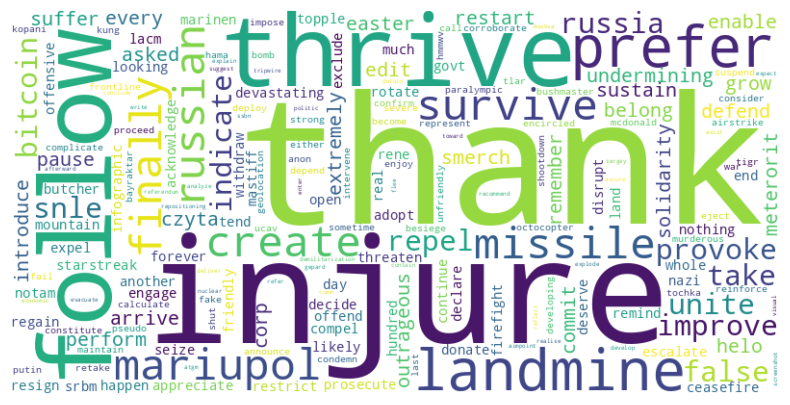

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from collections import Counter
import itertools


# Calculate document frequency of each word
# Flatten the list of lists into a single list
tokens_flat_w = list(itertools.chain.from_iterable(cleaned_tokens_w))

# Calculate document frequency of each word
word_document_freq = Counter(tokens_flat_w)

# Filter words based on document frequency
filtered_tokens = [token for token in set(tokens_flat_w)
                   if word_document_freq[token] / len(cleaned_tokens_w) <= 0.5]

# Concatenate filtered tokens into a single string
text_w = ' '.join(filtered_tokens)


# Generate word cloud
#all_tokens = [token for tokens in cleaned_tokens_w for token in tokens]
#text_w = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_w)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


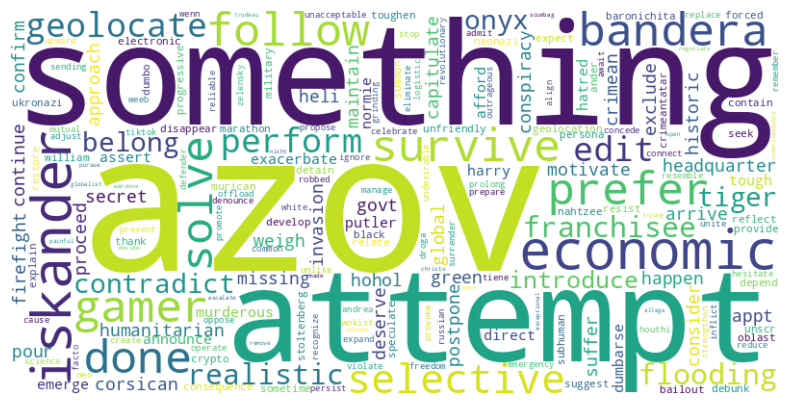

In [ ]:
# Calculate document frequency of each word
# Flatten the list of lists into a single list
tokens_flat_r = list(itertools.chain.from_iterable(cleaned_tokens_r))

# Calculate document frequency of each word
word_document_freq = Counter(tokens_flat_r)

# Filter words based on document frequency
filtered_tokens = [token for token in set(tokens_flat_r)
                   if word_document_freq[token] / len(cleaned_tokens_r) <= 0.5]

# Concatenate filtered tokens into a single string
text_r = ' '.join(filtered_tokens)


# Generate word cloud
#all_tokens = [token for tokens in cleaned_tokens_w for token in tokens]
#text_w = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_r)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()
